In [7]:
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch_geometric.datasets import Planetoid
from torch_geometric.data import Data
from torch_geometric.nn import GAE, GCNConv, VGAE
from tqdm import trange
from utils import evaluate_clustering, get_clusters, plot_training_history, plot_3d_clustering_comparison

# Variational Graph Autoencoder
From the paper [Graph Autoencoders](https://arxiv.org/pdf/1611.07308)
The paper uses this method for link prediction. However, it has also been used for graph clustering.

## Loading the data
We use the Cora dataset, a standard benchmark dataset for clustering.

In [8]:
dataset = Planetoid(root='../data/Planetoid', name='Cora')
data = dataset[0]
data.train_mask = data.test_mask = data.val_mask = None
data

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708])

## Encoder models
We define a simple encoder with two GCN layers for the Variational Graph Autoencoder. The GAE model only uses a latent vector $z$, while the VGAE model uses distribution parameters $\mu$ and $\log{\sigma^2}$.

In [9]:
class GCNEncoder(nn.Module):
		def __init__(self, in_channels, latent_dim):
				super(GCNEncoder, self).__init__()
				self.conv1 = GCNConv(in_channels, 2 * latent_dim)
				self.conv2 = GCNConv(2 * latent_dim, latent_dim)

		def forward(self, x, edge_index):
				x = F.relu(self.conv1(x, edge_index))
				return self.conv2(x, edge_index)

In [10]:
class VGCNEncoder(nn.Module):
		def __init__(self, in_channels, latent_dim):
				super(VGCNEncoder, self).__init__()
				self.conv1 = GCNConv(in_channels, 2 * latent_dim)
				self.conv_mu = GCNConv(2 * latent_dim, latent_dim)
				self.conv_logstd = GCNConv(2 * latent_dim, latent_dim)

		def forward(self, x, edge_index):
				x = F.relu(self.conv1(x, edge_index))
				return self.conv_mu(x, edge_index), self.conv_logstd(x, edge_index)

## Instantiating and training the models
The GAE and VGAE models are instantiated and trained with their built-in loss function, which uses the reconstruction loss and the KL divergence in the VGAE.

In [11]:
def train_model(model: nn.Module, data: Data, optimizer: optim.Optimizer, num_epochs: int = 200, tqdm_desc: str = "Epochs") -> np.ndarray:
	metrics = np.zeros((num_epochs, 5))
	for epoch in (pbar := trange(num_epochs, desc=tqdm_desc)):
		optimizer.zero_grad()
		z = model.encode(data.x, data.edge_index)
		loss = model.recon_loss(z, data.edge_index)
		if isinstance(model, VGAE):
				loss += (1 / data.num_nodes) * model.kl_loss()
		loss.backward()
		optimizer.step()
		z_np = z.detach().numpy()
		accuracy, nmi, ari, silouhette = evaluate_clustering(z_np, data.y, get_clusters(z_np, n_clusters))
		metrics[epoch] = np.array([loss.item(), accuracy, nmi, ari, silouhette])
		pbar.set_postfix({"Loss": loss.item(), "Accuracy": accuracy, "NMI": nmi, "ARI": ari, "Silouhette": silouhette})
	return metrics

In [12]:
latent_dim, num_epochs, lr, n_clusters = 16, 64, .01, len(np.unique(data.y.numpy()))

gae = GAE(GCNEncoder(data.num_features, latent_dim))
gae_optimizer = optim.Adam(gae.parameters(), lr=lr)

vgae = VGAE(VGCNEncoder(data.num_features, latent_dim))
vgae_optimizer = optim.Adam(vgae.parameters(), lr=lr)

In [13]:
gae_training = train_model(gae, data, gae_optimizer, num_epochs, "GAE")
vgae_training = train_model(vgae, data, vgae_optimizer, num_epochs, "VGAE")
history_labels = ['Loss', 'Accuracy', 'NMI Score', 'ARI Score', 'Silouhette Score']

VGAE: 100%|██████████| 64/64 [00:16<00:00,  3.85it/s, Loss=0.892, Accuracy=0.658, NMI=0.476, ARI=0.422, Silouhette=0.279]     


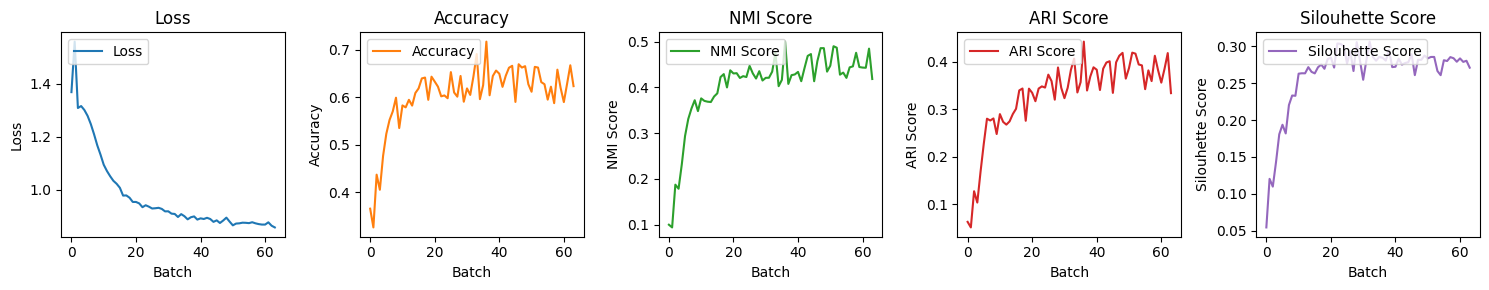

In [14]:
plot_training_history(history_labels, gae_training, "GAE")

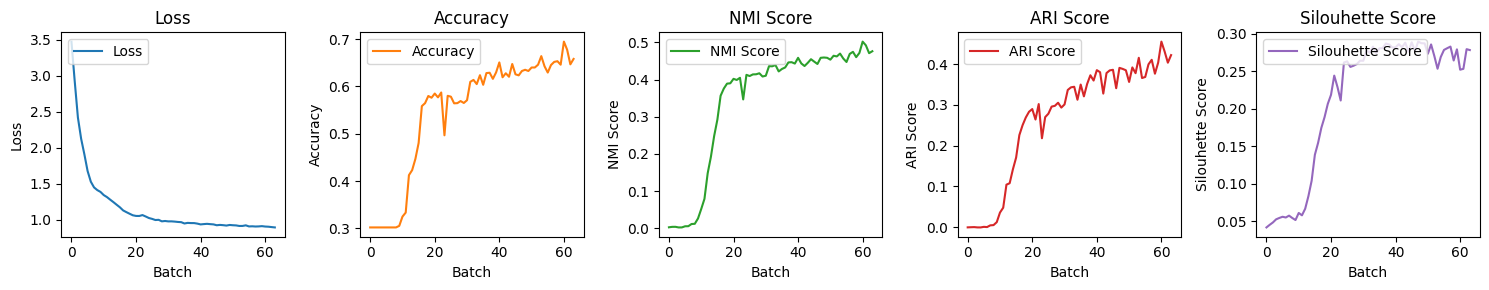

In [15]:
plot_training_history(history_labels, vgae_training, "VGAE")

In [16]:
gae_z, vgae_z = gae.encode(data.x, data.edge_index).detach().numpy(), vgae.encode(data.x, data.edge_index).detach().numpy()
gae_clusters, vgae_clusters = get_clusters(gae_z, n_clusters), get_clusters(vgae_z, n_clusters)

gae_accuracy, gae_nmi, gae_ari, gae_silouhette = evaluate_clustering(gae_z, data.y, gae_clusters)
vgae_accuracy, vgae_nmi, vgae_ari, vgae_silouhette = evaluate_clustering(vgae_z, data.y, vgae_clusters)

print(f"GAE Accuracy: {gae_accuracy:.4f}, NMI: {gae_nmi:.4f}, ARI: {gae_ari:.4f}, Silouhette: {gae_silouhette:.4f}")
print(f"VGAE Accuracy: {vgae_accuracy:.4f}, NMI: {vgae_nmi:.4f}, ARI: {vgae_ari:.4f}, Silouhette: {vgae_silouhette:.4f}")

GAE Accuracy: 0.6052, NMI: 0.4280, ARI: 0.3702, Silouhette: 0.2400
VGAE Accuracy: 0.6507, NMI: 0.4780, ARI: 0.4090, Silouhette: 0.2759


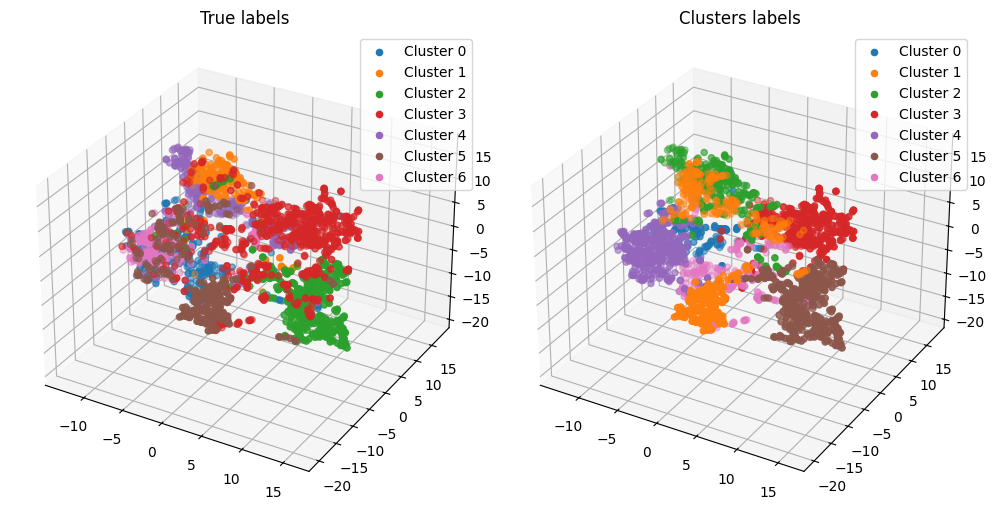

In [17]:
plot_3d_clustering_comparison(gae_z, data.y, gae_clusters, n_clusters)

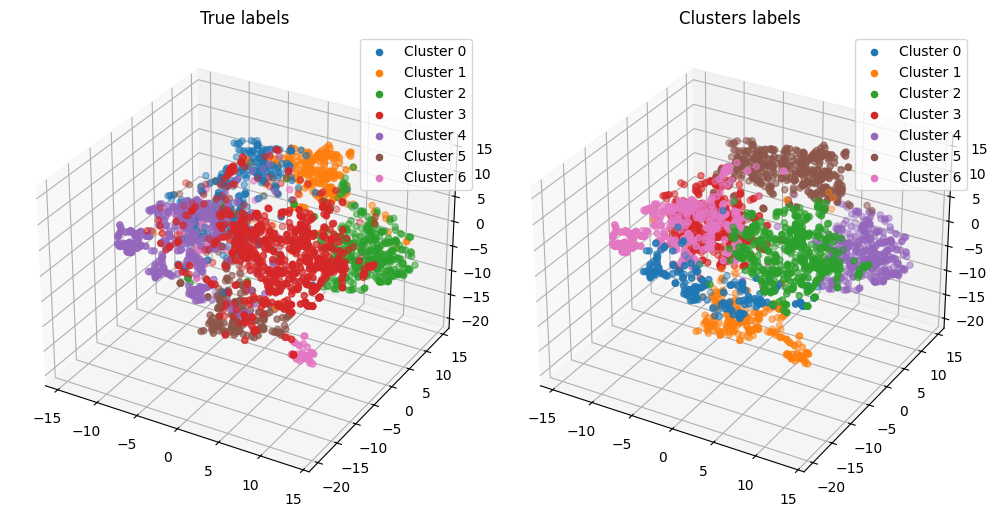

In [18]:
plot_3d_clustering_comparison(vgae_z, data.y, vgae_clusters, n_clusters)